In [401]:
from math import ceil
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import QFT
import numpy as np
import math
from fractions import Fraction
from math import gcd
from sympy.logic.boolalg import ANFform
import sympy as sp
from sympy.logic.boolalg import Boolean
from typing import List
from sympy import Array
Boolean.__rxor__ = Boolean.__xor__

# Grover search algorithm

In [343]:
def prepareGroverBlackBox(qubits: int, markedNumber: int):
    blackBox = QuantumCircuit(qubits, name="Grover's Black Box")
    if 2**(qubits-1)-1 < markedNumber:
        raise Exception('markedNumber is too Big')
    matrix = np.zeros((2**qubits, 2**qubits))
    for i in range(2**(qubits-1)):
        binaryNumber = bin(i)[2:].rjust(qubits-1, '0')
        if i == markedNumber:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'1', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'0', 2)] = 1
        else:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'0', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'1', 2)] = 1
    blackBox.unitary(matrix, range(qubits))
    return Operator(blackBox).to_instruction()

def inversionAboutMean(qubits: int):
    matrix = 2*np.full((2**qubits, 2**qubits), 1/(2**qubits)) - np.eye(2**qubits)
    inversionAboutMean = QuantumCircuit(qubits, name="Inversion About Mean")
    inversionAboutMean.unitary(matrix, range(qubits))
    return Operator(inversionAboutMean).to_instruction()
    
def grover(qubits: int, markedNumber:int):
    qc = QuantumCircuit(qubits+1, qubits)
    qc.x(qubits)
    qc.barrier()
    qc.h(range(qubits+1))
    numIterations = ceil(np.sqrt(2**qubits))
    print (numIterations)
    for _ in range(numIterations):
        qc.append(prepareGroverBlackBox(qubits+1, markedNumber), range(qubits,-1,-1))
        qc.append(inversionAboutMean(qubits), range(qubits-1,-1,-1))
    qc.measure(range(qubits), range(qubits))
    return qc

4
{'1001': 25, '1011': 37, '0000': 36, '0010': 33, '0101': 31, '1010': 34, '0100': 565, '1100': 26, '1110': 23, '1000': 34, '0011': 38, '0001': 26, '0110': 32, '0111': 24, '1101': 22, '1111': 38}
0010


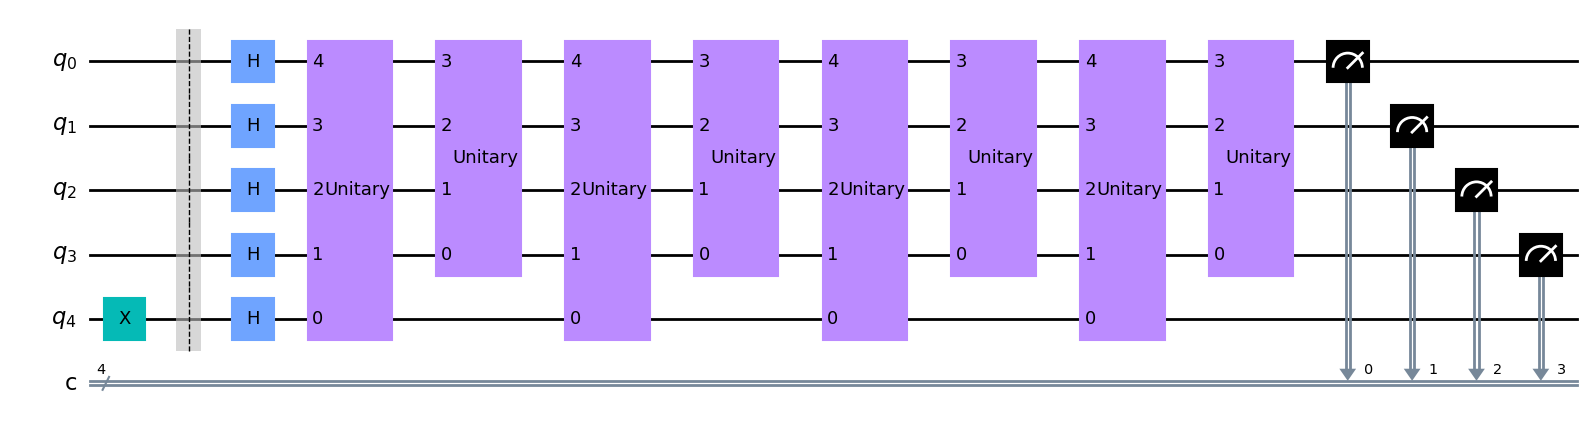

In [344]:
leng = 4
number = 2

qc = grover(leng, number)

backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
result = job.result()
print(result.get_counts())
counts = dict(result.get_counts())
max = 0
for key, value in counts.items():
    if value > max:
        max = value
        maxKey = key

print (maxKey[::-1])
qc.draw('mpl',style="clifford")

# Quantum lab

## **FA1**.

Duotajai qiskit schemai sympy priemonėmis raskite atitinkamą unitarinę transformaciją, atitinkamus tikrinius vektorius ir jų fazes. Užduoties variantai yra [>>>>](https://docs.google.com/document/d/1-y3EHC3zBhIUw13b7MMBeZGdQTyiWKQlb_RhP2Ez4n8/edit?usp=sharing)
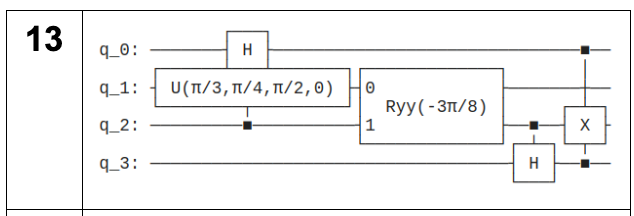

In [380]:
def hadamard() -> np.ndarray:
    return np.array([[1, 1], [1, -1]]) / np.sqrt(2)


def xGate() -> np.ndarray:
    return np.array([[0, 1], [1, 0]])


def cXGate() -> np.ndarray:
    return cU(xGate)


def xCGate() -> np.ndarray:
    return Uc(xGate)


def identity() -> np.ndarray:
    return np.array([[1, 0], [0, 1]])


def U(
    theta: float,
    phi: float,
    lam: float,
    gamma: float,
    qubits: int,
    control: int,
    target: int,
) -> np.ndarray:
    qc = QuantumCircuit(qubits)
    qc.cu(theta, phi, lam, gamma, control, target)
    return np.array(Operator(qc).to_matrix())


def cU(gate: callable) -> np.ndarray:
    matrix = gate()
    return np.array(
        [
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, matrix[0][0], matrix[0][1]],
            [0, 0, matrix[1][0], matrix[1][1]],
        ]
    )


def Uc(gate: callable) -> np.ndarray:
    matrix = gate()
    return np.array(
        [
            [1, 0, 0, 0],
            [0, matrix[0][0], 0, matrix[0][1]],
            [0, 0, 1, 0],
            [0, matrix[1][0], 0, matrix[1][1]],
        ]
    )


def ryy(theta: float) -> np.ndarray:
    qc = QuantumCircuit(2)
    qc.ryy(theta, 0, 1)
    return np.array(Operator(qc).to_matrix())


def ccx(control: List[int], target: int, qubits: int) -> np.ndarray:
    qc = QuantumCircuit(qubits)
    qc.ccx(control[0], control[1], target)
    return np.array(Operator(qc).to_matrix())


def task():
    qubits = 4
    matrix1 = np.kron(
        U(np.pi / 3, np.pi / 4, np.pi / 2, 0, qubits - 1, 1, 0), hadamard()
    )
    matrix2 = np.kron(identity(), np.kron(ryy(-3 * np.pi / 8), identity()))
    matrix3 = np.kron(Uc(hadamard), np.kron(identity(), identity()))
    matrix4 = ccx([0, 3], 2, qubits)

    matrix = matrix4 @ matrix3 @ matrix2 @ matrix1
    return matrix


def getEigenValues(matrix: np.ndarray) -> list:
    gate = sp.Matrix(matrix)
    eigenVals = gate.eigenvals()
    eigenVals = list(eigenVals.keys())
    print(eigenVals)
    return eigenVals


def getPhases(eigenValues: list) -> np.array:
    solvePhases = []
    for i in range(len(eigenValues)):
        x = sp.Symbol("x")
        solveTemp = list(sp.solve(sp.exp(2 * sp.pi * sp.I * x) - eigenValues[i], x))
        solvePhases.append(solveTemp)
    solvePhases = np.array(solvePhases).flatten()
    solvePhases = [abs(sp.re(i)) for i in solvePhases]
    solvePhases = np.unique(solvePhases)
    print(sp.Array(solvePhases))
    return solvePhases

### Fa1 qiskit

In [346]:
# contructed gate in qiskit to check whether final matrix is the same as the one we constructed manually
qc = QuantumCircuit(4)
qc.h(0)
qc.cu(np.pi/3,
       np.pi/4,
       np.pi/2,
       0,
       2,
       1)
qc.ryy(-3*np.pi/8, 1,2)
qc.ch(2,3)
qc.ccx(0,3,2)
sp.Matrix(Operator(qc).to_matrix())

Matrix([
[   0.587937801209679,    0.587937801209679,                   0,                    0, 0.1388925582549 - 0.138892558254901*I,  0.1388925582549 - 0.138892558254901*I,     0.240568967690708 + 0.240568967690708*I,     0.240568967690708 + 0.240568967690708*I,                    0,                    0,                    0,                    0,                                      0,                                      0,                                           0,                                           0],
[   0.587937801209679,   -0.587937801209679,                   0,                    0, 0.1388925582549 - 0.138892558254901*I, -0.1388925582549 + 0.138892558254901*I,     0.240568967690708 + 0.240568967690708*I,    -0.240568967690708 - 0.240568967690708*I,                    0,                    0,                    0,                    0,                                      0,                                      0,                                           0,      

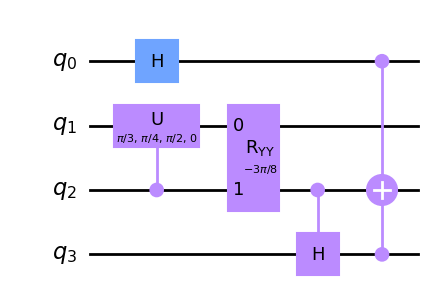

In [347]:
qc.draw('mpl', style='clifford')

### Fa1 manually

In [381]:
eigenValues = getEigenValues(task())
phases = getPhases(eigenValues)
sp.Matrix(task())

[0.755214791767952 + 0.655477397241803*I, 0.85895535236854 + 0.51205048836754*I, 0.990203901575364 + 0.139628912854488*I, 0.998129619018774 - 0.0611331631558295*I, 0.969254425288031 - 0.246060681661186*I, 0.819395509522366 - 0.573228574806404*I, 0.622662666446359 - 0.782490385764522*I, 0.327804961514034 - 0.94474541925684*I, -0.2370565807109 - 0.97149584535481*I, -0.0114688210941917 + 0.999934230908568*I, -0.879047382580519 - 0.476734411573507*I, -0.999108495776622 - 0.0422162725376704*I, -0.998340563437264 + 0.0575857568828096*I, -0.745265466135864 + 0.666767864391568*I, -0.799679710200908 + 0.600426815767743*I, -0.936547270515497 + 0.350541310104776*I]
[0.00973571569278093, 0.022295482249048, 0.0395681260406129, 0.0855569681016363, 0.0971546454425544, 0.113766274054657, 0.143025449239469, 0.19684555659811, 0.251825359586167, 0.288091339548219, 0.383838626463324, 0.397498688352173, 0.420910173374029, 0.442998812149937, 0.490829869162235, 0.493279074183403, 0.506720925816597, 0.5091701

Matrix([
[   0.587937801209679,    0.587937801209679,                   0,                    0, 0.1388925582549 - 0.138892558254901*I,  0.1388925582549 - 0.138892558254901*I,     0.240568967690708 + 0.240568967690708*I,     0.240568967690708 + 0.240568967690708*I,                    0,                    0,                    0,                    0,                                      0,                                      0,                                           0,                                           0],
[   0.587937801209679,   -0.587937801209679,                   0,                    0, 0.1388925582549 - 0.138892558254901*I, -0.1388925582549 + 0.138892558254901*I,     0.240568967690708 + 0.240568967690708*I,    -0.240568967690708 - 0.240568967690708*I,                    0,                    0,                    0,                    0,                                      0,                                      0,                                           0,      

**FA2**. Sukurkite trijų kubitų  schemą, kurioje turi būti X, CX, H vartai. Jos  unitarinei matricai atlikite fazės aproksimacijos algoritmą qiskit aplinkoje. Palyginkite rastą $\theta$ reikšmę su tiksliąją (kurią Jūs galite rasti panašiai kaip FA1 užduotyje).

## Fa2 gate and precise phases

In [383]:
matrix1= np.kron(hadamard(),cXGate())
matrix2 = np.kron(cXGate(),xGate())
matrix = matrix2 @ matrix1

eigenValues = getEigenValues(matrix)
getPhases(eigenValues)
sp.Matrix(matrix)

[-1.0 - 2.13256662881934e-64*I, -1.0 + 5.2607684349724e-64*I, 4.76799102247836e-64 - 1.0*I, 0.707106781186547 - 0.707106781186547*I, 1.0 - 5.08614875123355e-65*I, 1.0 + 3.35602154603014e-64*I, 0.707106781186547 + 0.707106781186547*I, 8.15902465342222e-65 + 1.0*I]
[8.0948571505949e-66, 5.34127418173601e-65, 0.125, 0.25, 0.5, 0.75, 0.875, 1.0]


Matrix([
[                0, 0.707106781186547,                 0,                 0,                  0,  0.707106781186547,                  0,                  0],
[0.707106781186547,                 0,                 0,                 0,  0.707106781186547,                  0,                  0,                  0],
[                0,                 0, 0.707106781186547,                 0,                  0,                  0,  0.707106781186547,                  0],
[                0,                 0,                 0, 0.707106781186547,                  0,                  0,                  0,  0.707106781186547],
[                0,                 0, 0.707106781186547,                 0,                  0,                  0, -0.707106781186547,                  0],
[                0,                 0,                 0, 0.707106781186547,                  0,                  0,                  0, -0.707106781186547],
[                0, 0.707106781186547,     

### Fa2 qiskit

In [391]:
def task2Gate():
    qc = QuantumCircuit(3)
    qc.h(2)
    qc.cx(1,0)
    qc.x(0)
    qc.cx(2,1)
    return qc.to_gate()

def phaseEstimationCircuit(controlQubits:int) -> QuantumCircuit:
    gate = task2Gate()
    qc = QuantumCircuit(controlQubits+gate.num_qubits, controlQubits)

    qc.h(range(controlQubits))
    qc.x(qc.num_qubits-1)
    qc.barrier()
    for i in range(controlQubits):
        for _ in range(2**i):
            cU = gate.control(1)
            qc.append(cU, [i] + list(range(controlQubits,controlQubits+gate.num_qubits)))
        qc.barrier()

    qc.append(QFT(controlQubits, do_swaps=False).inverse(), range(controlQubits))
    qc.measure(range(controlQubits), range(controlQubits))    
    return qc

def getEstimatedPhases(controlQubits:int, shots:int) -> np.ndarray:
    qc = phaseEstimationCircuit(controlQubits)
    backend = Aer.get_backend('qasm_simulator')
    transpiled = transpile(qc, backend, seed_transpiler=11)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    count = list(result.get_counts().items())
    count.sort(key = lambda x: x[1])
    count.reverse()
    count = [(int(x,2)/2**controlQubits,y/shots) for x,y in count]
    return np.array(count)

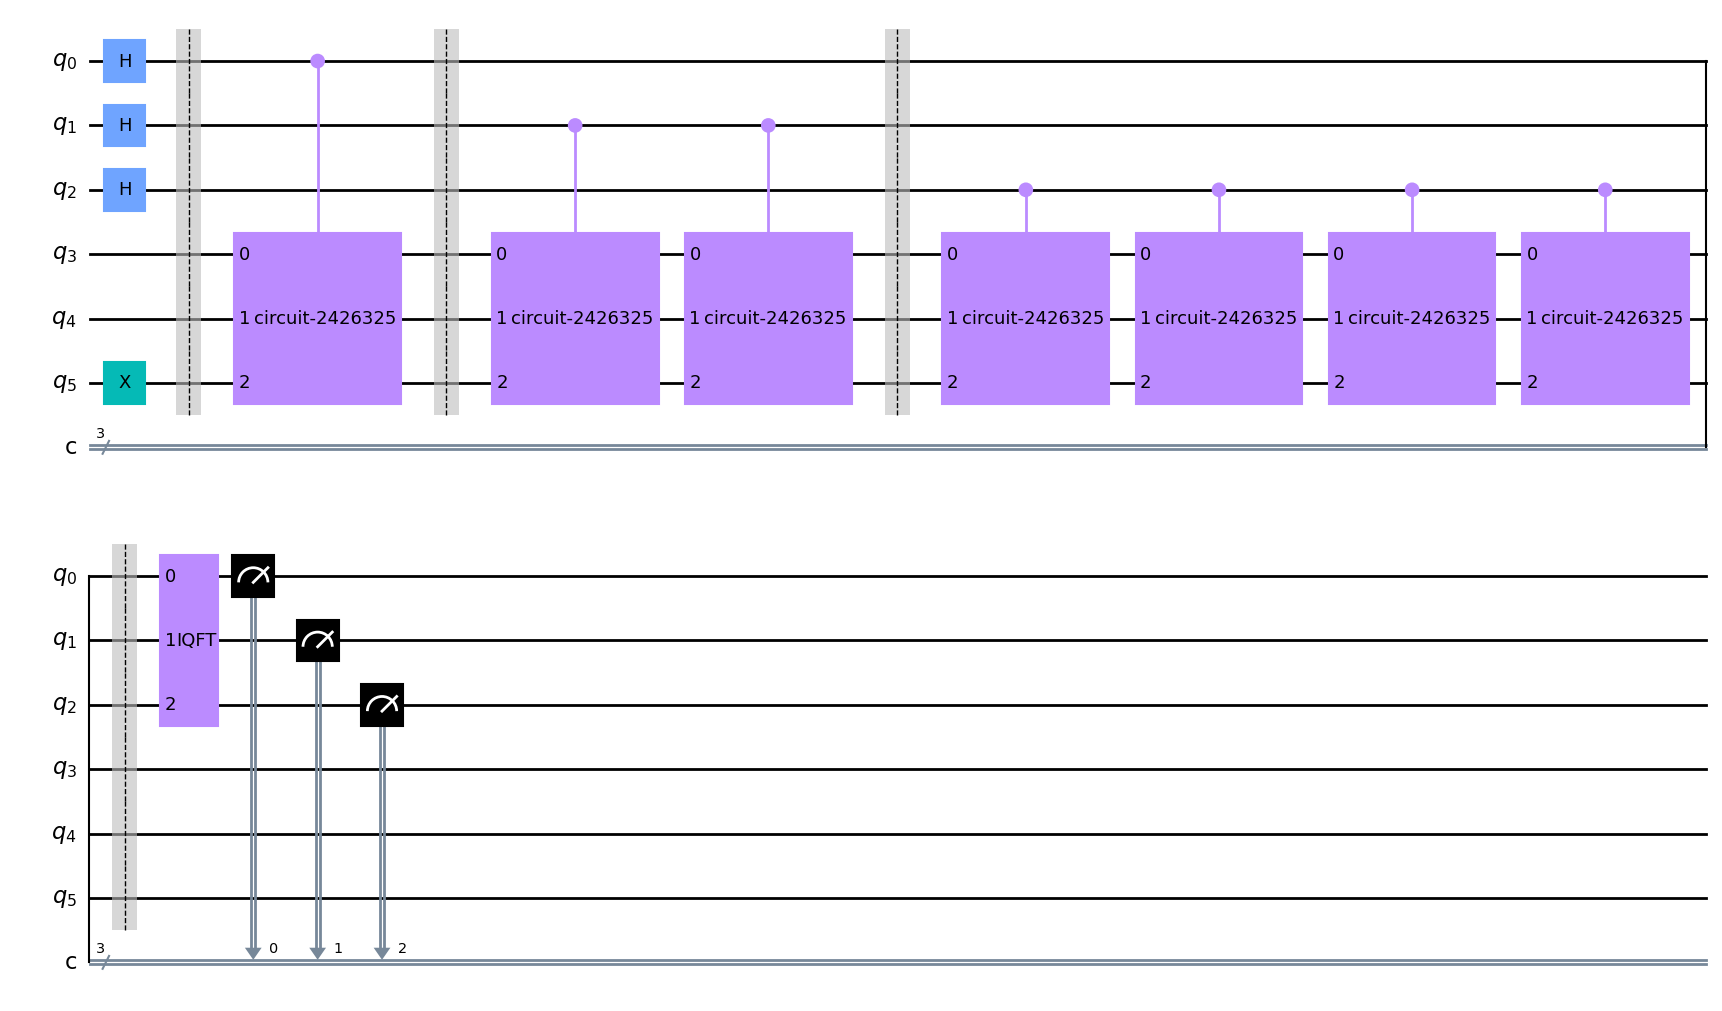

In [400]:
phaseEstimationCircuit(3).draw('mpl', style='clifford')

### Fa2 gate matrix

In [388]:
qc = QuantumCircuit(3)
qc.append(task2Gate(), range(3))
sp.Matrix(Operator(qc).to_matrix())

Matrix([
[                0, 0.707106781186547,                 0,                 0,                  0,  0.707106781186547,                  0,                  0],
[0.707106781186547,                 0,                 0,                 0,  0.707106781186547,                  0,                  0,                  0],
[                0,                 0, 0.707106781186547,                 0,                  0,                  0,  0.707106781186547,                  0],
[                0,                 0,                 0, 0.707106781186547,                  0,                  0,                  0,  0.707106781186547],
[                0,                 0, 0.707106781186547,                 0,                  0,                  0, -0.707106781186547,                  0],
[                0,                 0,                 0, 0.707106781186547,                  0,                  0,                  0, -0.707106781186547],
[                0, 0.707106781186547,     

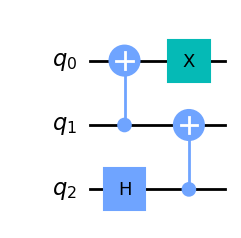

In [390]:
qc.decompose().draw('mpl', style='clifford')

### Fa2 calculating estimated phases

In [399]:
controlQubits = 3
shots = 4096
estimatedPhases = getEstimatedPhases(controlQubits, shots)
print("computed phases:")
print (sp.Array(estimatedPhases))
print("actual phases:")
print(sp.Array(phases))

computed phases:
[[0.125, 0.201416015625], [0.875, 0.198486328125], [0.75, 0.145751953125], [0.25, 0.144287109375], [0.5, 0.109130859375], [0.0, 0.104736328125], [0.625, 0.049072265625], [0.375, 0.047119140625]]
actual phases:
[0.00973571569278093, 0.022295482249048, 0.0395681260406129, 0.0855569681016363, 0.0971546454425544, 0.113766274054657, 0.143025449239469, 0.19684555659811, 0.251825359586167, 0.288091339548219, 0.383838626463324, 0.397498688352173, 0.420910173374029, 0.442998812149937, 0.490829869162235, 0.493279074183403, 0.506720925816597, 0.509170130837765, 0.557001187850063, 0.579089826625971, 0.602501311647827, 0.616161373536676, 0.711908660451781, 0.748174640413834, 0.80315444340189, 0.856974550760531, 0.886233725945343, 0.902845354557446, 0.914443031898364, 0.960431873959387, 0.977704517750952, 0.990264284307219]


## **O1.**
 Duotiesiems $N$ ir $a$ raskite operatoriaus $M_a$ matricą (žr. daugiau [>>>>](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring#order-finding))

Variantai:
1. $N=27, a=10$

In [352]:
N = 27
a = 10

array = np.zeros((N,N))
for i in range(N):
    array[a*i%N][i] = 1

Array(array)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

## **ShA**.
 Panagrinėkite Šoro algoritmo implementaciją [>>>>](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring#implementation-in-qiskit). Funkciją c_amod15(a) pakeiskite analogiška funkcija pagal Jūsų  variantą ir atlikite korekcijas kitose funkcijose taip, kad galima būtų išskaidyti duotąjį $N$:


1. $N=187$;


In [353]:
basisGates = ['cx','swap','x','u', 'id','ccx','cccx','cswap']
backend = Aer.get_backend('qasm_simulator')

def getGate(a,N):
    qubits = math.ceil(math.log(N,2))
    letters = []
    for i in range(qubits):
        letter = chr(ord('a') + i)
        letters.append(letter)

    modulus = []
    for i in range(2**qubits):
        if i < N:
            modulus.append((i,(a*i)%N))
        else:
            modulus.append((i,i))

    truthValues = []
    for index in range(qubits):
        tempTruthValues = []
        for i in range(2**qubits):
            _, value = modulus[i]
            tempTruthValues.append(bin(value)[2:].rjust(qubits, '0')[index])
        truthValues.append(tempTruthValues)

    allANFs = []
    print (truthValues)
    for i in range(len(truthValues)):
        truthValuesI =[ int(j) for j in truthValues[i]]
        anfForm = ANFform(letters, truthValuesI).__str__()
        print(anfForm)
        anf = anfForm.split(" ^ ")
        for i in range(len(anf)):
            anf[i]= anf[i].replace("(", "").replace(")", "")
            anf[i] = anf[i].split(" & ")
            for j in range(len(anf[i])):
                if anf[i][j] != "True":
                    for k in range(len(letters)):
                        anf[i][j] = anf[i][j].replace(letters[k], str(k))
                    anf[i][j] = int(anf[i][j])
        allANFs.append(anf)

    qc = QuantumCircuit(2*qubits)
    ind = qubits

    for i in range(len(allANFs)):
        for j in range(len(allANFs[i])):
            if allANFs[i][j][0] == 'True':
                qc.x(ind)
            else:
                qc.mcx(allANFs[i][j], ind)
        ind+=1
    qc.swap(range(qubits), range(qubits,2*qubits))
    
    return qc.to_gate()

def getCoprimeListWithEvenPeriod(N):
    aList = []
    for i in range(N-1):
        if gcd(i,N) == 1 and i != 1:
            remainder = 0
            count = 1
            while remainder != 1:
                if remainder == 0:
                    remainder = (i)%N
                remainder = (remainder*i)%N
                count += 1
            if count%2 == 0:
                if gcd(i**(count//2)-1,N) != 1 and gcd(i**(count//2)+1,N) != 1:
                    aList.append(i)
    return aList

def generateAModMatrix(a,N):
    qc = QuantumCircuit(math.ceil(math.log(N,2)))
    qubits = math.ceil(math.log(N,2))
    matrix = np.zeros((2**qubits, 2**qubits))
    for i in range(0,2**qubits):
        if i < N:
            matrix[a*i%N][i] = 1
        else:
            matrix[i][i] = 1
    qc.unitary(matrix, range(qubits))
    return Operator(qc)

def aMod15(x,gat,size):
    qc = QuantumCircuit(size)
    for _ in range(x):
        qc.append(gat, range(size-1,-1,-1))
    unitary = qc.to_gate()
    return unitary.control(1)

def prepareCircuits(n,N,a):
    transpiledCircuits = []
    gate = generateAModMatrix(a,N)
    # specGate = getGate(a,N)
    # get qubits
    # print(specGate.num_qubits)
    # specGate = specGate.control(1)

    
    for i in range(n):
        print(i+1, "th circuit out of ", n)
        qubits = math.ceil(math.log(N,2))
        # qc = QuantumCircuit(qubits*3)# was *2
        # testing
        # for _ in range(2**i):
        #     qc.append(specGate, [i] + list(range(qubits,qubits*3)))
        # qc.reset(range(qubits*2, qubits*3))
        qc = QuantumCircuit(qubits*2)
        qc.append(aMod15(1,gate,qubits), [i]+list(range(qubits,qubits*2)))
        # transpiled = transpile(qc, backend= backend, basis_gates=basisGates, optimization_level=3,seed_transpiler=11)
        # transpiledCircuits.append(transpiled)
        transpiledCircuits.append(qc)
    return transpiledCircuits

def shor(n:int, N:int, m:int, a:int=2):
    # qc = QuantumCircuit(n+m+m, n)   
    qc = QuantumCircuit(n+m, n)   
    
    qc.h(range(n))
    qc.x(n+m-1)
    qc.barrier()
    print(n)
    transpiledCircuits = prepareCircuits(n,N,a)
    for i in range(n):
        # x = 2**i
        # for _ in range(x):
        # qc.append(transpiledCircuits[i],range(n+m+m))
        qc.append(transpiledCircuits[i],range(n+m))
    qc.barrier()
    qc.append(Operator(QFT(n).inverse()).to_instruction(), range(n))
    qc.measure(range(n), range(n))
    return qc

def processMeasurement(measurement,n):
    binaryString = ''.join(map(str, measurement))
    measuredInt = int(binaryString,2)
    phase = measuredInt/(2**n)
    f = Fraction.from_float(phase).limit_denominator(n)
    _,r = f.numerator, f.denominator
    print ("corresponding phase",phase," r ",r)
    return r, phase

In [354]:
N = 33
n=math.ceil(math.log(N,2))
m=math.ceil(math.log(N,2))
coprimeListWithEvenPeriods = getCoprimeListWithEvenPeriod(N)
print (coprimeListWithEvenPeriods)
if len(coprimeListWithEvenPeriods) == 0:
    raise Exception('No coprime list with even periods found')
coprime = False
while coprime == False:
    a = np.random.randint(2, N)
    if a in coprimeListWithEvenPeriods:
        coprime = True

factorFound = False
attempts = 0
print ("trying with a=",a,"and N=",N)
qc = shor(n,N,m,a)
print("shor constructed")
# t_gate = transpile(qc, backend, basis_gates=basisGates, seed_transpiler=11)
qcc = qc.decompose(reps=2)
print("transpiled")
while factorFound == False:
    attempts += 1
    # job = backend.run(t_gate, shots=1)
    job = backend.run(qcc, shots=1)
    result = job.result()
    counts = list(result.get_counts().keys())
    print ("attempts",attempts,"counts",counts)
    r, phase = processMeasurement(counts[0],n)
    if phase != 0 and r%2 == 0:
        guesses = [math.gcd(a**(r//2)-1,N), math.gcd(a**(r//2)+1,N)]
        print ("guesses",guesses)
        for guess in guesses:
            if guess not in [1,N] and N%guess == 0:
                factorFound = True
                print ("Found non trivial factors of",N,"; ",guess,"and",N//guess)
                break

[5, 7, 10, 13, 14, 19, 20, 23, 26, 28]
trying with a= 19 and N= 33
6
1 th circuit out of  6
2 th circuit out of  6
3 th circuit out of  6
4 th circuit out of  6
5 th circuit out of  6
6 th circuit out of  6
shor constructed
transpiled
attempts 1 counts ['010001']
corresponding phase 0.265625  r  4
guesses [3, 1]
Found non trivial factors of 33 ;  3 and 11


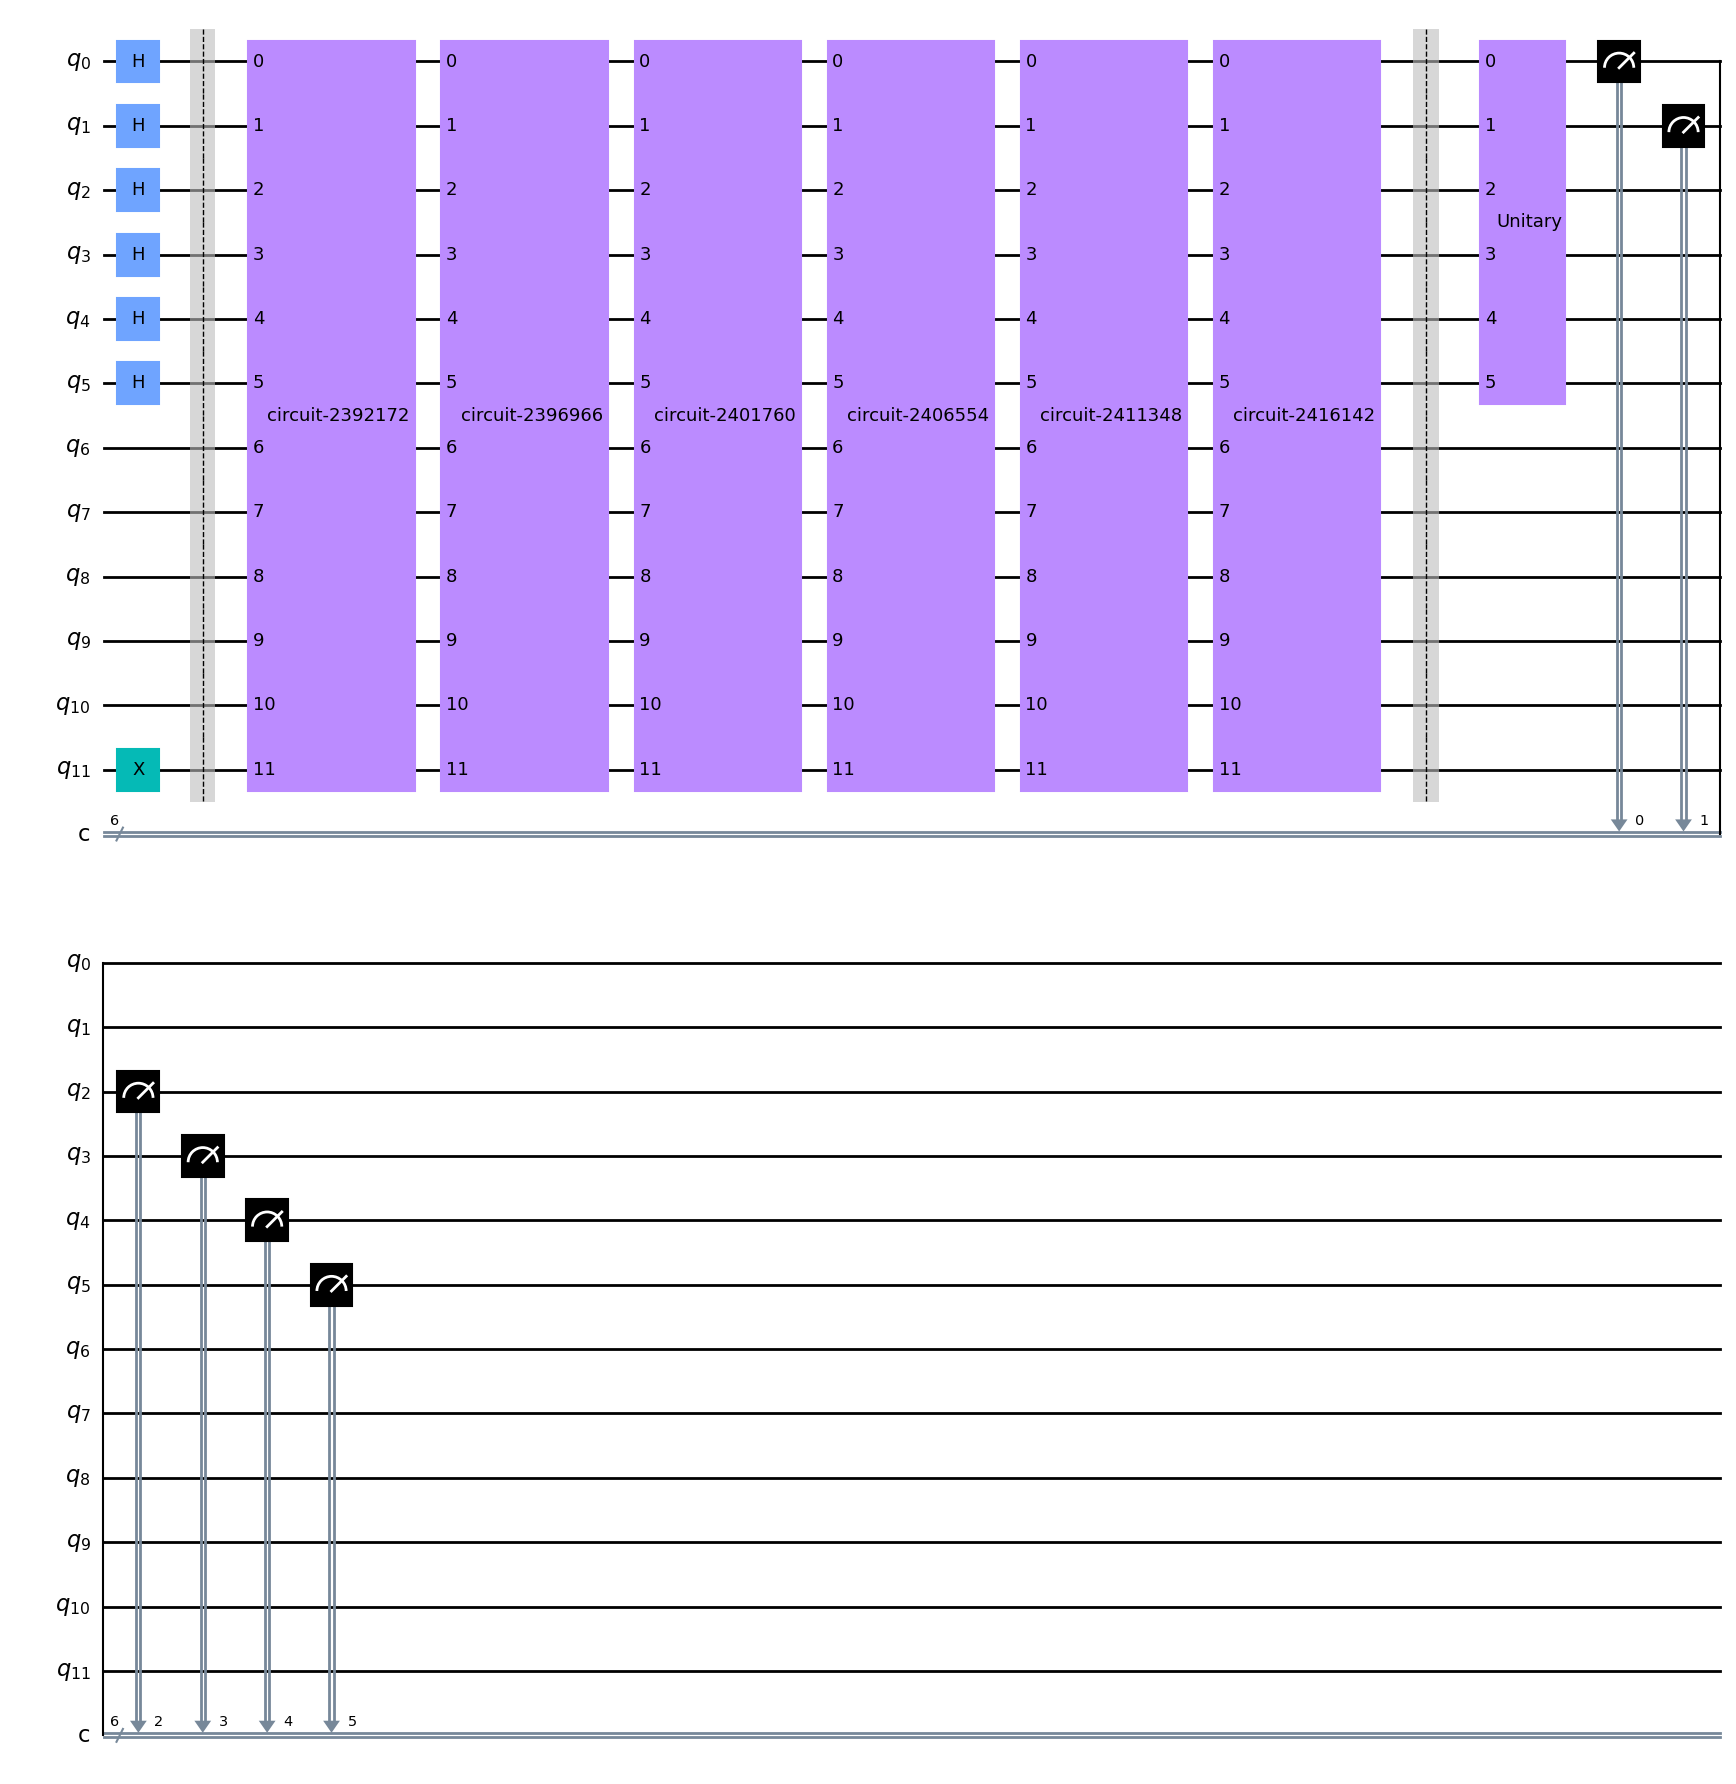

In [355]:
qc.draw('mpl',style="clifford")